In [1]:
import sysid
import pylab as pl
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# create 'ss1' state space system
ss1 = sysid.StateSpaceDiscreteLinear(
    A=0.9, B=0.5, C=1, D=0, Q=0.1, R=0.01, dt=0.1)
ss1

{'B': matrix([[ 0.5]]), 'dt': 0.1, 'Q': matrix([[ 0.1]]), 'C': matrix([[1]]), 'A': matrix([[ 0.9]]), 'D': matrix([[0]]), 'R': matrix([[ 0.01]])}

In [3]:
#pl.seed(1234)
# create pseudorandom binary sequence
prbs1 = sysid.prbs(1000)
def f_prbs(t, x, i):
    return prbs1[i]
prbs1[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [4]:
tf = 10
# create simulated data
# inputs, initial states x0 = 0
data = ss1.simulate(f_u=f_prbs, x0=pl.matrix(0), tf=tf)
# perform a subspace ID on this simulated data
# y = output data, u = input data
# f = future, p = past
ss1_id = sysid.subspace_det_algo1(y=data.y, u=data.u,
    f=5, p=5, s_tol=1e-1, dt=ss1.dt)
# created simulated data from the system identified
data_id = ss1_id.simulate(f_u=f_prbs, x0=0, tf=tf)
ss1_id

{'B': matrix([[ 0.63369534]]), 'dt': 0.1, 'Q': matrix([[ 0.]]), 'C': matrix([[ 1.]]), 'A': matrix([[ 0.87357049]]), 'D': matrix([[ 0.00328361]]), 'R': matrix([[ 0.]])}

fit 90.865001%


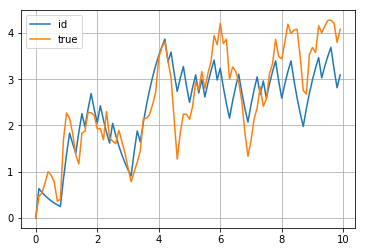

In [5]:
pl.plot(data_id.t.T, data_id.x.T, label='id'); # plot states x vs t for ID'd data
pl.plot(data.t.T, data.x.T, label='true');     # plot states x vs t for original data
pl.legend()
pl.grid()
print('fit {:f}%'.format(100*sysid.subspace.nrms(data_id.y, data.y)))

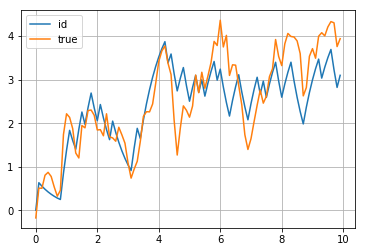

In [6]:
pl.plot(data_id.t.T, data_id.y.T, label='id'); # plot measurements y vs t for ID'd data
pl.plot(data.t.T, data.y.T, label='true');     # plot measurements y vs t for original data
pl.legend()
pl.grid()

In this case the C matrix, which converts the internal system states into measurements (aka outputs), is the identity matrix.  This means that the measurements are the same as the internal states.

In [7]:
ss2 = sysid.StateSpaceDiscreteLinear(
    A=pl.matrix([[0,0.1,0.2],[0.2,0.3,0.4],[0.4,0.3,0.2]]),
    B=pl.matrix([[1,0],[0,1],[0,-1]]),
    C=pl.matrix([[1,0,0],[0,1,0]]), D=pl.matrix([[0,0],[0,0]]),
    Q=pl.diag([0.1,0.1,0.1]), R=pl.diag([0.04,0.04]), dt=0.1)
ss2

{'B': matrix([[ 1,  0],
        [ 0,  1],
        [ 0, -1]]), 'dt': 0.1, 'Q': matrix([[ 0.1,  0. ,  0. ],
        [ 0. ,  0.1,  0. ],
        [ 0. ,  0. ,  0.1]]), 'C': matrix([[1, 0, 0],
        [0, 1, 0]]), 'A': matrix([[ 0. ,  0.1,  0.2],
        [ 0.2,  0.3,  0.4],
        [ 0.4,  0.3,  0.2]]), 'D': matrix([[0, 0],
        [0, 0]]), 'R': matrix([[ 0.04,  0.  ],
        [ 0.  ,  0.04]])}

In [8]:
pl.seed(1234)
prbs1 = sysid.prbs(1000)
prbs2 = sysid.prbs(1000)
def f_prbs_2d(t, x, i):
    i = i%1000
    return 2*pl.matrix([prbs1[i]-0.5, prbs2[i]-0.5]).T

In [9]:
tf = 10
data2 = ss2.simulate(
    f_u=f_prbs_2d, x0=pl.matrix([0,0,0]).T, tf=tf)
ss2_id = sysid.subspace_det_algo1(y=data2.y, u=data2.u,
    f=5, p=5, s_tol=0.2, dt=ss2.dt)
data2_id = ss2_id.simulate(
    f_u=f_prbs_2d,
    x0=pl.matrix(pl.zeros(ss2_id.A.shape[0])).T, tf=tf)
ss2_id

{'B': matrix([[-0.28131732,  0.16276378],
        [-0.18072485, -0.26856789],
        [ 0.04412118,  0.05350001]]), 'dt': 0.1, 'Q': matrix([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'C': matrix([[-2.58965971, -1.48742189,  0.74307248],
        [ 1.86386335, -2.51789334, -0.16987682]]), 'A': matrix([[ 0.03829981,  0.04312282,  0.06438357],
        [ 0.28348555,  0.0641748 ,  0.57361551],
        [ 0.35214808,  0.28316853,  0.26047993]]), 'D': matrix([[-0.07224252, -0.00296524],
        [-0.05782543, -0.1301545 ]]), 'R': matrix([[ 0.,  0.],
        [ 0.,  0.]])}

fit 90.848732%


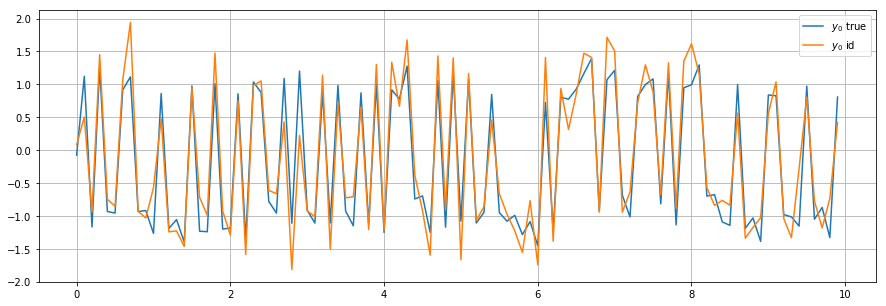

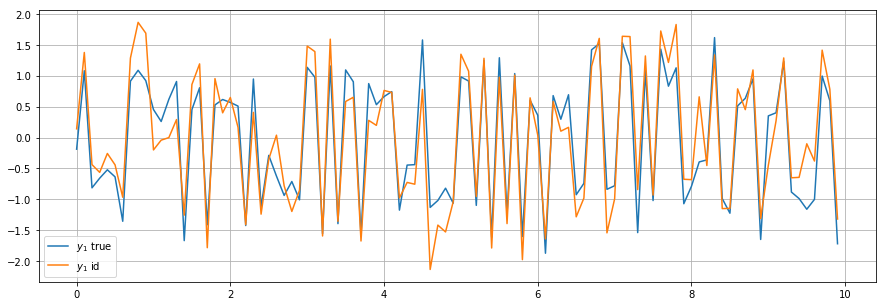

In [10]:
for i in range(2):
    pl.figure(figsize=(15,5))
    pl.plot(data2_id.t.T, data2_id.y[i,:].T,
            label='$y_{:d}$ true'.format(i))
    pl.plot(data2.t.T, data2.y[i,:].T,
            label='$y_{:d}$ id'.format(i))
    pl.legend()
    pl.grid()
print('fit {:f}%'.format(100*sysid.subspace.nrms(data2_id.y, data2.y)))

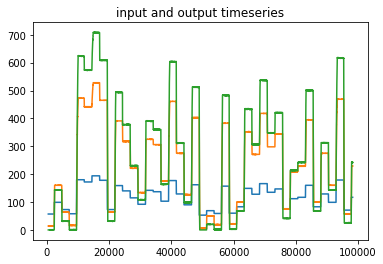

In [46]:
import numpy
from matplotlib import pyplot as plt

# import the data from the constrained run
data = numpy.genfromtxt('002.csv',delimiter=',',dtype=int,
                        skip_header=100,max_rows=20000,invalid_raise=False)
# plot the raw timeseries
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(data[:,0],data[:,1])
ax.plot(data[:,0],data[:,2])
ax.plot(data[:,0],data[:,3])
ax.set_title("input and output timeseries")
#ax.plot(data[:,0],data[:,3])
#fig.show()

t = data[:,0:1]
u = data[:,1:2] - 50
y1 = data[:,2:3]
y2 = data[:,3:4]

/home/brandon/.virtualenvs/python3/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


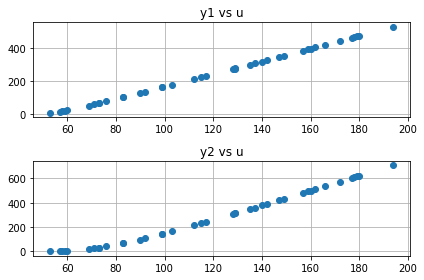

In [48]:
# attempt to extract the equilibrium values
lineprev = None # numpy.array([[0,0,0,0]])
equilib = None  # numpy.array([[0,0,0,0]])
iprev = None
#print(equilib)
for line in data:
    i = line[1]
    #print(line,i)
    line = numpy.array([line])
    #print(line)
    try:
        iprev = lineprev[0,1]
    except:
        pass
    if i != iprev and lineprev is not None:
        if equilib is None:
            equilib = lineprev
        else:
            equilib = numpy.append(equilib,lineprev,axis=0)
    lineprev = line

    
# plot equilibrium values, inputs vs outputs
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(equilib[:,1],equilib[:,2],marker='o',linestyle='None')
ax.grid()
ax.set_title("y1 vs u")

ax2 = fig.add_subplot(2,1,2)
ax2.plot(equilib[:,1],equilib[:,3],marker='o',linestyle='None')
ax2.grid()
ax2.set_title("y2 vs u")

fig.tight_layout()
fig.show()

In [51]:
# perform a subspace ID on this simulated data
# y = output data, u = input data
# f = future, p = past
dt = (t[-1,0]-t[0,0]) / 20000
ss1_id = sysid.subspace_det_algo1(y1.T, u.T, f=5, p=5, s_tol=1e-1, dt=dt)
# created simulated data from the system identified
ss1_id

{'B': matrix([[ 0.14578131]]), 'dt': 4.8934, 'Q': matrix([[ 0.]]), 'C': matrix([[ 1.]]), 'A': matrix([[ 0.9569981]]), 'D': matrix([[ 0.14796839]]), 'R': matrix([[ 0.]])}

In [52]:
# perform a subspace ID on this simulated data
# y = output data, u = input data
# f = future, p = past
ss2_id = sysid.subspace_det_algo1(y2.T, u.T, f=5, p=5, s_tol=1e-1, dt=dt)
# created simulated data from the system identified
ss2_id

{'B': matrix([[ 0.13030281]]), 'dt': 4.8934, 'Q': matrix([[ 0.]]), 'C': matrix([[ 1.]]), 'A': matrix([[ 0.96681196]]), 'D': matrix([[ 0.50103833]]), 'R': matrix([[ 0.]])}

## Plot and Verify y1, current through LED

fit 97.156383%


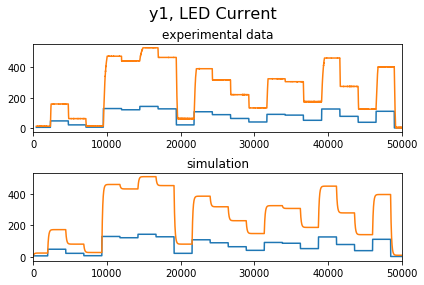

In [87]:
finaltime = 50000

def f_u(t, x, i):
    return u[i]

data_id = ss1_id.simulate(f_u=f_u, x0=0, tf=finaltime)
id_t = data_id.t.T
id_u = data_id.u.T
id_y = data_id.y.T
lid = len(id_t) # length of ID sequence
exp_t = t[:lid]
exp_u = u[:lid]
exp_y = y1[:lid]

fig = plt.figure()
fig.suptitle("y1, LED Current", fontsize=16)

ax1 = fig.add_subplot(2,1,1)
ax1.plot(exp_t,exp_u)
ax1.plot(exp_t,exp_y)
ax1.set_xlim([0,finaltime])
ax1.set_title("experimental data")
ax2 = fig.add_subplot(2,1,2)
ax2.plot(id_t,id_u)
ax2.plot(id_t,id_y)
ax2.set_xlim([0,finaltime])
ax2.set_title("simulation")

fig.tight_layout()
fig.subplots_adjust(top=0.85)

print('fit {:f}%'.format(100*sysid.subspace.nrms(id_y,exp_y)))

## Plot and Verify y2, phototransistor current

fit 93.866007%


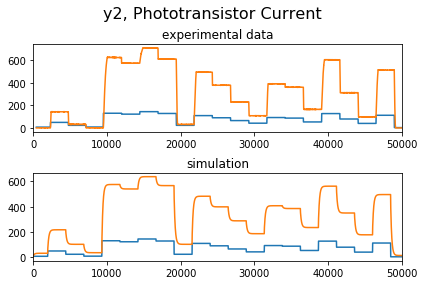

In [84]:
finaltime = 50000

def f_u(t, x, i):
    return u[i]

data_id = ss2_id.simulate(f_u=f_u, x0=0, tf=finaltime)
id_t = data_id.t.T
id_u = data_id.u.T
id_y = data_id.y.T
lid = len(id_t) # length of ID sequence

fig = plt.figure()
fig.suptitle("y2, Phototransistor Current", fontsize=16)

ax1 = fig.add_subplot(2,1,1)
ax1.plot(t[:lid],u[:lid])
ax1.plot(t[:lid],y2[:lid])
ax1.set_xlim([0,finaltime])
ax1.set_title("experimental data")
ax2 = fig.add_subplot(2,1,2)
ax2.plot(id_t,id_u)
ax2.plot(id_t,id_y)
ax2.set_xlim([0,finaltime])
ax2.set_title("simulation")

fig.tight_layout()
fig.subplots_adjust(top=0.85)

print('fit {:f}%'.format(100*sysid.subspace.nrms(id_y,y2[:lid])))